In [1]:
import anndata as ad
import spateo as st

import scanpy as sc ### had some problem installing dynamo. thus using scanpy for preprocessing and plotting, for demo only.

In [3]:
### These functions should have been replace with dynamo/spateo functions, but I have not looked into it yet.
import numpy as np

def prefilter_genes(adata,min_counts=None,max_counts=None,min_cells=10,max_cells=None):
    if min_cells is None and min_counts is None and max_cells is None and max_counts is None:
        raise ValueError('Provide one of min_counts, min_genes, max_counts or max_genes.')
    id_tmp=np.asarray([True]*adata.shape[1],dtype=bool)
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,min_cells=min_cells)[0]) if min_cells is not None  else id_tmp
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,max_cells=max_cells)[0]) if max_cells is not None  else id_tmp
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,min_counts=min_counts)[0]) if min_counts is not None  else id_tmp
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,max_counts=max_counts)[0]) if max_counts is not None  else id_tmp
    adata._inplace_subset_var(id_tmp)


def prefilter_specialgenes(adata,Gene1Pattern="ERCC",Gene2Pattern="MT-"):
    id_tmp1=np.asarray([not str(name).startswith(Gene1Pattern) for name in adata.var_names],dtype=bool)
    id_tmp2=np.asarray([not str(name).startswith(Gene2Pattern) for name in adata.var_names],dtype=bool)
    id_tmp=np.logical_and(id_tmp1,id_tmp2)
    adata._inplace_subset_var(id_tmp)

In [30]:
# Args
adata_path = "data/spagcn_sample_data.h5ad"
his_img_path = "data/spagcn_sample_histology.tif"
n_clusters = 7

### Here I'm using the toy data on spagcn-website, which can be downloaded from https://drive.google.com/drive/folders/1qOTTYW7S2TzAJZJ4g-eK8RQQM2bAwd-x

In [31]:
# Load the data
adata = ad.read(adata_path)

In [32]:
# Preprocessing
adata.var_names_make_unique()
prefilter_genes(adata,min_cells=3)
prefilter_specialgenes(adata)

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [33]:
# Find Clusters using spagcn
st.tl.find_clusters(adata, method="spagcn", n_clusters=n_clusters, his_img_path=his_img_path, x_array = "x2", y_array = "x3", x_pixel = "x4", y_pixel = "x5")

# For spagcn, If have not a histology image, you can use total UMIs(nCounts) to generate a grayscale image,
# acting as a 'histology image', with following code:
# 
# st.tl.find_clusters(adata, method="spagcn", n_clusters=n_clusters, total_umi="n_counts", x_array = "x2", y_array = "x3", his_img_path=None)

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  33.30687202862215 174.55510595352243 46.84205750749746
Var of x,y,z =  390.6990007265343 942.1320230796399 942.1320230796398
Run 1: l [0.01, 1000], p [0.0, 3629.7406229057815]
Run 2: l [0.01, 500.005], p [0.0, 3605.191162109375]
Run 3: l [0.01, 250.0075], p [0.0, 3510.2841796875]
Run 4: l [0.01, 125.00874999999999], p [0.0, 3176.00439453125]
Run 5: l [0.01, 62.509375], p [0.0, 2292.207275390625]
Run 6: l [0.01, 31.2596875], p [0.0, 1045.66015625]
Run 7: l [0.01, 15.63484375], p [0.0, 292.8680419921875]
Run 8: l [0.01, 7.822421875], p [0.0, 59.20486831665039]
Run 9: l [0.01, 3.9162109375], p [0.0, 9.650460243225098]
Run 10: l [0.01, 1.9631054687499998], p [0.0, 1.330838918685913]
Run 11: l [0.9865527343749999, 1.9631054687499998], p [0.1348710060119629, 1.330838918685913]
Run 12: l [0.9865527343749999, 1.4748291015625], p [0.1348710060119629, 0.547426700592041]
Run 13: l [1.23069091796875, 1.4748291015625], p [0.3007076

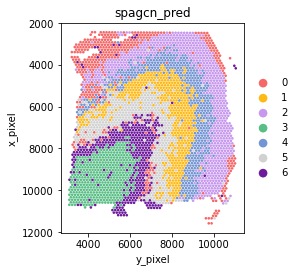

In [34]:
# plot clustering result
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
domains="spagcn_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
